In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd
import matplotlib.ticker as ticker
import scipy as sp
import assortment_functions as af # this is the assortment_functions.py file
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
from collections import Counter
# from numba import njit, prange

### This may produce warning signs (comment out if needed)
font = {        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

import scipy.io
mat = sp.io.loadmat('dynamic_parameters.mat')
par_dist = np.zeros((3,2,11))
par_dist[0,0,:] = mat['Win1'].reshape(12)[:-1]
par_dist[0,1,:] = mat['Win2'].reshape(12)[:-1]

par_dist[1,0,:] = mat['Deadlock1'].reshape(12)[:-1]
par_dist[1,1,:] = mat['Deadlock2'].reshape(12)[:-1]

par_dist[2,0,:] = mat['Lose1'].reshape(12)[:-1]
par_dist[2,1,:] = mat['Lose2'].reshape(12)[:-1]

def poll_fraction(g,n):
    party = g.nodes[n]['party']
    delta = 1 # Since the node knows it will vote for its own party
    neighbours = list(g.neighbors(n))
    for m in neighbours:
        if g.nodes[m]['party'] == party:
            delta+=1
    delta = delta/(len(neighbours)+1)
    return delta

def dynamics(g,last=False,ass=False,late=False,full_ig=False,par_mean=False):
    V = 0.6 # Super-majority
    
    T = 240 # Total length of game in seconds
    t_decision = 3.3 # The time between updates
    t = 0
    
    t_transition = 83 # Transition between early and late
    no_decisions = int(T//t_decision) # No of updates
    
    polls = np.array([poll_fraction(g,n) for n in g]) # 
    initial_parties = np.array(list(nx.get_node_attributes(g,'party').values()))
    intentions = np.zeros((no_decisions+1,len(g)))
    intentions[0,:] = initial_parties
    
    if full_ig:
        IG = np.zeros(no_decisions+1)
        IG[0] = af.influence_gap(g,absolute=False)
    
    if ass:
        assortment = np.zeros((no_decisions+1,2))
        assortment[0,:] = list(af.party_assortment(g).values())
    
    rand_numbers = np.random.rand(no_decisions+1,len(g))
    
    pars = np.zeros((3,2,len(g)))
    for i in range(3):
        for j in range(2):
            if not par_mean:
                pars[i,j,:] = np.random.choice(np.linspace(0,1,11),p=par_dist[i,j,:],size=len(g))
            else:
                pars[i,j,:] = mean_prob[i,j]
    
    phase = 0 # Early
    for t_index in range(1,no_decisions+1):
        t += t_decision
#         t_index = int(t//t_decision)
        if t > 83:
            phase = 1 # Late
            if late & (t<83+3.3):
                IG = af.influence_gap(g,absolute=False)
        pars_now = np.zeros(len(g))
        pars_now[polls>=V] = pars[0,phase,polls>=V]
        pars_now[(polls>=1-V)&(polls<V)] = pars[1,phase,(polls>=1-V)&(polls<V)]
        pars_now[polls<1-V] = pars[2,phase,polls<1-V]
        
        if full_ig:
            IG[t_index] = af.influence_gap(g,absolute=False)
        
        for n in g:
            if rand_numbers[t_index,n] <= pars_now[n]:
                intentions[t_index,n] = int(initial_parties[n])
            else:
                intentions[t_index,n] = int(1 - initial_parties[n])
        parties_dict = {n:int(intentions[t_index,n]) for n in g}
        nx.set_node_attributes(g,parties_dict,'party')
        # CORRECTION LINE 27/5/21
        polls = np.array([poll_fraction(g,n) for n in g])
        # END OF CORRECTION 27/5/21
        if ass:
            assortment[t_index,:]=list(af.party_assortment(g).values())
#         print(t_index)
#         print(initial_parties)
    if last:
        return intentions[-1,:]
    elif late:
        return IG,np.sum(intentions[-1,:])/len(g)-0.5
    elif ass:
        return assortment
    elif full_ig:
        return IG,np.sum(intentions,axis=1)/len(g) - 0.5
    else:
        return intentions

# Example dynamics

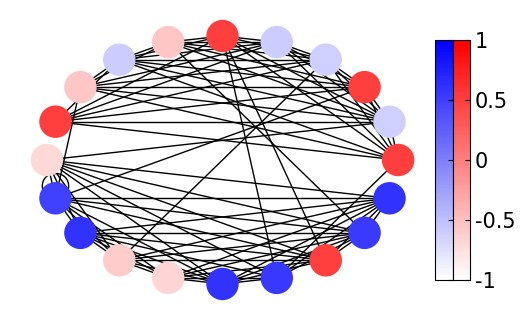

In [50]:
N = 20
fig = plt.figure(figsize=(5,3))
# g = nx.caveman_graph(2,10)
# g = nx.relaxed_caveman_graph(2,10,0.2)
node_list = np.random.choice(range(N),size=(N//2),replace=False)
parties = {n:int(n in node_list) for n in range(N)}
g = af.homophilic_relaxed_caveman_graph(2,N//2,0.3,0.3,parties)
# nx.set_node_attributes(g,parties,'party')

pos = nx.shell_layout(g)
af.draw_assortment(g,pos=pos)

votes = dynamics(g)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


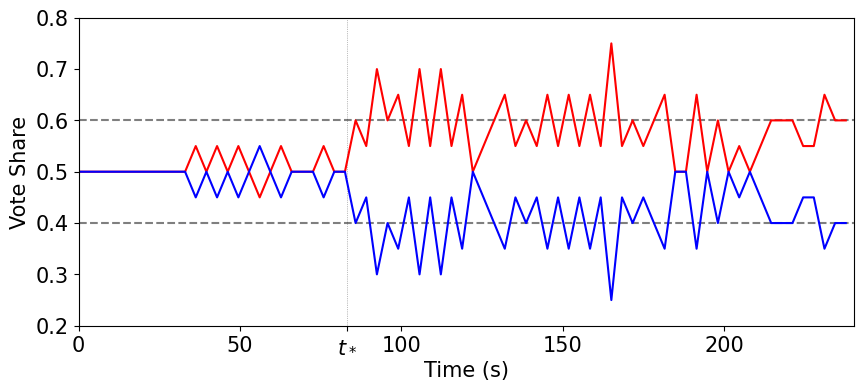

In [53]:
fig = plt.figure(figsize=(10,4))

plt.plot([83,83],[0,1],'k:',alpha=0.5,linewidth=0.5)
plt.plot([0,240],[0.6,0.6],'k--',alpha=0.5)
plt.plot([0,240],[1-0.6,1-0.6],'k--',alpha=0.5)

plt.plot(np.arange(0,240,3.3),np.sum(votes,axis=1)/20,color='red')
plt.plot(np.arange(0,240,3.3),1-np.sum(votes,axis=1)/20,color='blue')

plt.ylim([0.2,0.8])
plt.xlim([0,240])

plt.xticks([0,50,83,100,150,200],[0,50,'$t_*$',100,150,200])

plt.ylabel("Vote Share")
plt.xlabel("Time (s)")

fig.savefig("Dynamics/Corrections 27-5-21/Two Parties/Manuscript Figures/Dynamics_example.eps",bbox_inches='tight',format='eps')

# hRC Surface Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


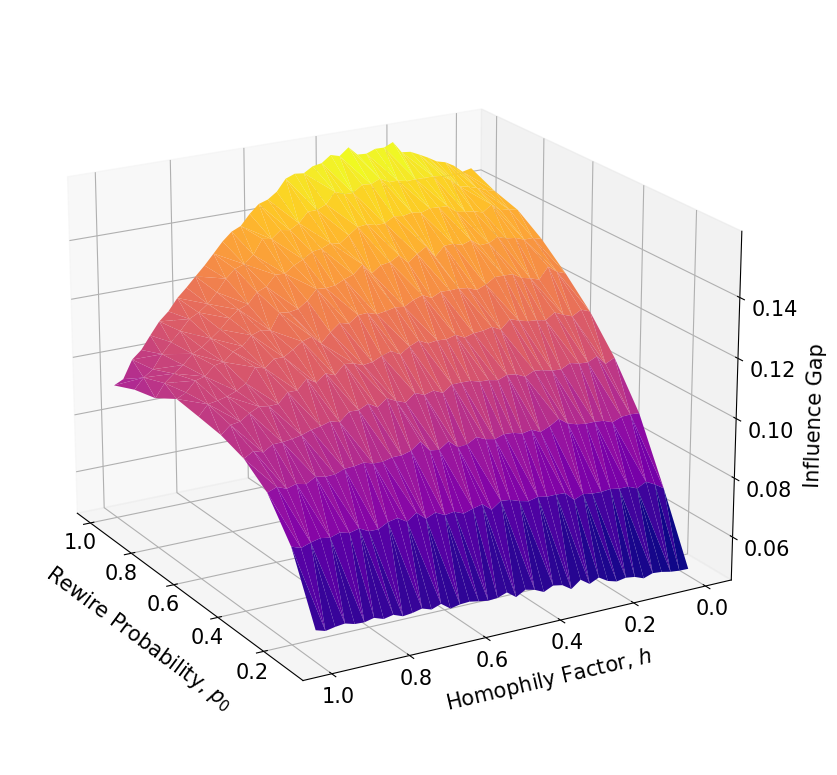

In [55]:
df = pd.read_csv("Static/Misc/CSVs/hRC-p0-h2-means-precise.csv")
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(df["Rewire Probability"],df["Homophily Factor"],df["Influence Gap"],
                cmap=plt.cm.plasma, linewidth=0.2)
# ax.view_init(25, 150)
ax.view_init(20, 150)

ax.set_xlabel("Rewire Probability, $p_0$",labelpad=9)
ax.set_ylabel("Homophily Factor, $h$",labelpad=7)
ax.set_zlabel("Influence Gap",labelpad=11)

ax.tick_params(axis='x', which='major', pad=-1)
ax.tick_params(axis='y', which='major', pad=-1)
ax.tick_params(axis='z', which='major', pad=6)

# fig.text(0.5,0.9,"Mean of Influence Gap of hRC Graphs",ha='center')

# plt.title("Mean of Influence Gap of hRC Graphs")
fig.tight_layout()

fig.savefig("Static/Misc/Figures/hRC-surface2-mean-precise.eps",bbox_inches='tight',format='eps')

# Two Parties

100%|█████████████████████████████████████| 10000/10000 [04:12<00:00, 39.59it/s]


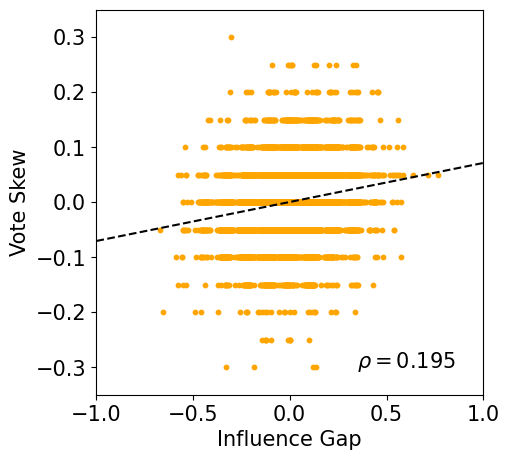

In [20]:
## RCs for p=0.3
N=20
samples = 10000
IG = np.zeros(samples)
VS = np.zeros(samples)

for i in trange(samples):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}
    G = nx.relaxed_caveman_graph(2,10,0.3)
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G)
    VS[i] = np.sum(af.dynamics(G,last=True))/N - 0.5
    
folder='Dynamics/Corrections 27-5-21/Two Parties/Manuscript Figures/'
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=10,alpha=1,c='orange')
plt.ylim([-0.35,0.35])
plt.xlim([-1,1])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Vote Skew')
plt.annotate(r'$\rho = {0}$'.format(round(r.rvalue,4)),(0.35,-0.3))
fig.savefig(folder+"Dynamics_RC_scatter_p03.eps",bbox_inches='tight',format='eps')

In [2]:
# hRCs
folder='Dynamics/Corrections 27-5-21/Two Parties/'
PCC = np.zeros((11,3,4))
p = [0,0.4,1]
h = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
samples=10000

dfs = pd.read_csv(folder+'hRC_all_samples{0}a.csv'.format(samples))
for i in range(11):
    for j in range(3):
        df = dfs[(dfs['Homophily']==h[i]) & (dfs['Rewire']==p[j])]
        PCC[i,j,0] = sp.stats.linregress(df['IG'],df['VS']).rvalue
        PCC[i,j,1] = sp.stats.linregress(df['Majority'],df['VS']).rvalue
        PCC[i,j,2] = sp.stats.linregress(df['dVS'],df['VS']).rvalue
        PCC[i,j,3] = sp.stats.linregress(df['EG'],df['VS']).rvalue

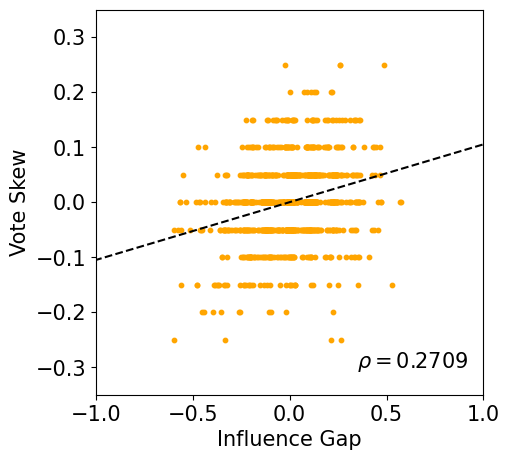

In [18]:
df_ = dfs[(dfs['Homophily']==0.3) & (dfs['Rewire']==1) & (dfs['Majority']==0)]
IG = df_['IG']
VS = df_['VS']

fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=10,alpha=1,c='orange')
plt.ylim([-0.35,0.35])
plt.xlim([-1,1])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Vote Skew')
plt.annotate(r'$\rho = {0}$'.format(round(r.rvalue,4)),(0.35,-0.3))
fig.savefig(folder+'Manuscript Figures/'+"Dynamics_hRC_scatter_p1h03.eps",bbox_inches='tight',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


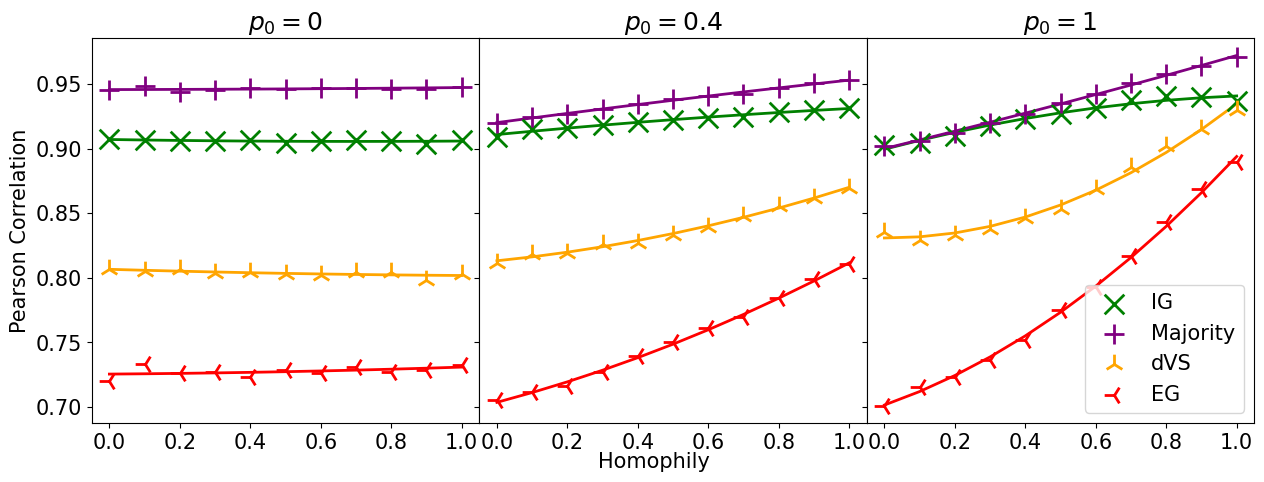

In [4]:
color_dict={'IG':'green','Majority':'purple','dVS':'orange','EG':'red'}
markers= {'IG':'x','Majority':'+','dVS':'2','EG':'3'}
metrics = ['IG','Majority','dVS','EG']

fig,axs=plt.subplots(ncols=3,figsize=(15,5),sharey=True)
plt.subplots_adjust(wspace=0)
for j in range(3):
#     fig=plt.figure(figsize=(8,7))
    for k in range(len(metrics)):
        metric = metrics[k]
        pars = np.polyfit(h,PCC[:,j,k],2)
        axs[j].plot(h,pars[0]*np.array(h)**2+pars[1]*np.array(h)+pars[2],lw=2,
                    color=color_dict[metric],zorder=0)
        axs[j].scatter(h,PCC[:,j,k],color=color_dict[metric],marker=markers[metric],label=metric,
                       s=200,lw=2,linewidths=3)
    axs[j].set_title("$p_0 = {0}$".format(p[j]))
fig.text(0.5, 0.02, 'Homophily', ha='center')
axs[0].set_ylabel("Pearson Correlation")
axs[2].legend()
#     plt.legend()
#     plt.xlabel('Homophily')
#     plt.ylabel('PCC')
fig.savefig(folder+'Manuscript Figures/'+'hRC_correlations_p{0}_samples{1}a_3in1.eps'.format(p[j],samples),format='eps',bbox_inches='tight')

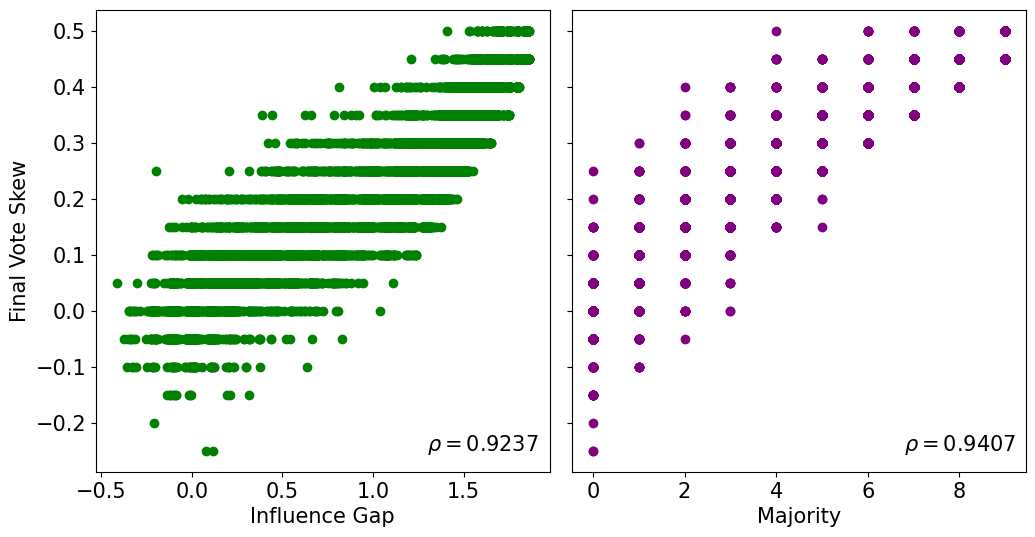

In [7]:
dfs = pd.read_csv(folder+'hRC_all_samples10000a.csv')
df_ = dfs[(dfs['Homophily']==0.6) & (dfs['Rewire']==0.4)]
rho_ig = sp.stats.linregress(df_['IG'],df_['VS']).rvalue
rho_maj = sp.stats.linregress(df_['Majority'],df_['VS']).rvalue


fig,axs=plt.subplots(figsize=(12,6),ncols=2,sharey=True)
plt.subplots_adjust(wspace = 0.05)
axs[0].scatter(df_['IG'],df_['VS'],color='green')
axs[0].annotate(r'$\rho = {0}$'.format(round(rho_ig,4)),(1.3,-0.25))

axs[1].scatter(df_['Majority'],df_['VS'],color='purple')
axs[1].annotate(r'$\rho = {0}$'.format(round(rho_maj,4)),(6.8,-0.25))

axs[0].set_ylabel('Final Vote Skew')
axs[0].set_xlabel('Influence Gap')
axs[1].set_xlabel('Majority')
# plt.hist2d(x='IG',y='VS',data=df_,cmap='Greens',norm=mpl.colors.LogNorm());
# plt.hist2d(x='Majority',y='VS',data=df_,cmap='Greens',norm=mpl.colors.LogNorm());
# plt.colorbar()
fig.savefig(folder+'Manuscript Figures/'+'hRC_p04_h06_samples10000a.eps',
            format='eps',bbox_inches='tight')

# Three Parties

In [56]:
folder = 'Dynamics/Corrections 27-5-21/Multiparty/'
PCC = np.zeros((11,3,2,3))
p = [0,0.4,1]
h = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
samples=10260
dfs = pd.read_csv(folder+'hRC_all_samples{0}.csv'.format(samples))

ig = [[],[],[]]
pf = [[],[],[]]
for j in range(3):
    for i in range(11):
        df = dfs[(dfs['Homophily']==h[i]) & (dfs['Rewire']==p[j])]
        for party in range(3):
            PCC[i,j,0,party] = sp.stats.linregress(df['IG_{0}'.format(party)],
                                               df['Party_{0}_final'.format(party)]).rvalue
            PCC[i,j,1,party] = sp.stats.linregress(df['Party_{0}_initial'.format(party)],
                                               df['Party_{0}_final'.format(party)]).rvalue
            ig[party].append(PCC[i,j,0,party])
            pf[party].append(PCC[i,j,1,party])
            
# data = {'Rewire':rew,'Homophily':hom,
#         'rho_IG0':ig[0],'rho_IG1':ig[1],'rho_IG2':ig[2],
#         'rho_PF0':pf[0],'rho_PF1':pf[1],'rho_PF2':pf[2]}
# df_pcc=pd.DataFrame(data=data).to_csv(folder+'hRC_pcc_samples{0}.csv'.format(samples),index=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


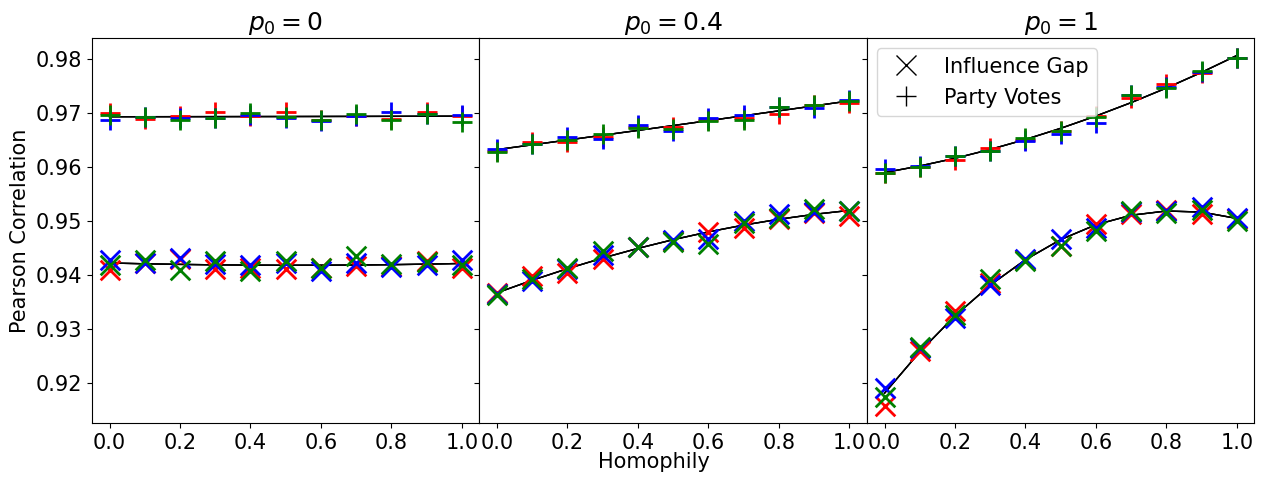

In [58]:
color_dict={0:'red',1:'blue',2:'green'}
markers= {'Influence Gap':'x','Party Votes':'+'}
metrics = ['Influence Gap','Party Votes']

fig,axs=plt.subplots(ncols=3,figsize=(15,5),sharey=True)
plt.subplots_adjust(wspace=0)
for j in range(3):
#     fig=plt.figure(figsize=(8,7));
    for k in range(2):
        metric = metrics[k]
        for party in range(3):
            x_train = h*3
            y_train = PCC[:,j,k,:].transpose().flatten()
            pars = np.polyfit(x_train,y_train,2)
            axs[j].plot(h,pars[0]*np.array(h)**2+pars[1]*np.array(h)+pars[2],lw=1,color='k',zorder=0)
#             plt.plot(h,PCC[:,j,k,party],color=color_dict[party],marker=markers[metric],#label=metric,
#                 ms=10,lw=2,markeredgewidth=3);
            axs[j].scatter(h,PCC[:,j,k,party],color=color_dict[party],marker=markers[metric],#label=metric,
                s=200,lw=2,linewidths=3);
#             pars = np.polyfit()
#         axs[j].plot(h,PCC[:,j,k,:].mean(axis=1),'k',lw=0.5)
#     plt.legend()
    
#     plt.xlabel('Homophily');
#     plt.ylabel('PCC');
    axs[j].set_title("$p_0 = {0}$".format(p[j]))
    
metric_patches = [axs[2].plot([], [], markers[metric],label=metric, 
                               markersize=15,markerfacecolor='w',markeredgecolor='k')[0] 
                      for metric in metrics]
axs[2].legend()
axs[0].set_ylabel("Pearson Correlation")
fig.text(0.5, 0.02, 'Homophily', ha='center')

fig.savefig(folder+'hRC_correlations_samples{0}_3in1.eps'.format(samples),
            bbox_inches='tight',format='eps')
#     fig.savefig(folder+'hRC_correlations_p{0}_samples{1}.png'.format(p[j],samples),bbox_inches='tight')